## Data preparation

This workflow demonstrate how to prepare training and testing data mainly using sequential Gaussian simulation (SGS).

Outlines:
1. walk through realiztaions calculation using Sequential Gaussian Simulation (SGS) 
2. training data
4. testing data

### SGS

In [1]:
# import some packages
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import math
import geostatspy
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
# Let's make a dummy data set with a parametric distribution; 
X_uncon = np.full(1000,-999999.9)
Y_uncon = np.full(1000,-999999.9)
Por = np.random.normal(loc = 0.15,scale = 0.03,size=1000)  

df = pd.DataFrame({'X':X_uncon,'Y':Y_uncon,'Por':Por})
df.head()

,X,Y,Por
0,-999999.9,-999999.9,0.144498
1,-999999.9,-999999.9,0.126267
2,-999999.9,-999999.9,0.102742
3,-999999.9,-999999.9,0.150807
4,-999999.9,-999999.9,0.116075


* hmaj - the range for this nested structure in the major direction
* hmin - the range for this nested structure in the minor direction
* nug - nugget effect contribution to sill
* nst - number of nested structures (1 or 2)
* it - type for this nested structure (1 - spherical, 2 - exponential, 3 - Gaussian)
* cc - contribution of each nested structure (contributions + nugget must sum to the sill)
* azi - the azimuth for this nested structure of the major direction, the minor is orthogonal

In [3]:
# SGSIM parameters setting
nx = 224; ny = 224; #number of cells
xsiz = 5.0; ysiz = 5.0; #cell size
xmn = xsiz/2; ymn = ysiz/2; # grid origin, location center of lower left cell

#basic indicator kriging parameters
ndmin = 0; ndmax = 20; # minimum and maximum data for kriging 
radius = 1000; # maximum search distance
ktype = 1; # kriging type, 0 - simple, 1 - ordinary
skmean = 0  
tmin = -999; tmax = 999  # data trimming limits

#check one realization first
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)
sim = geostats.sgsim(df,'X','Y','Por',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,
            zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73085,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=1,colocorr=0.0,sec_map=0,vario=vario)



 Data for SGSIM: Number of acceptable data     = 1000
                 Number trimmed                = 0
                 Weighted Average              = 0.1504
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9987
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 25088
Reassigning data to nodes

 Realization 0: number   = 50176
                                   mean     = -0.0509 (close to 0.0?)
                                   variance = 0.7348 (close to gammabar(V,V)? approx. 1.0)


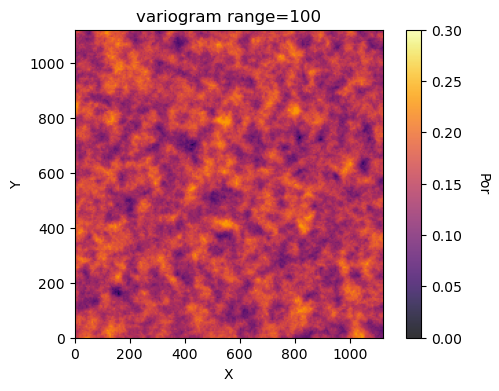

In [4]:
xmin = 0.0; xmax = nx*xsiz; ymin = 0.0; ymax = ny*ysiz; 
cmap = plt.cm.inferno #color map

plt.figure(figsize=(6,4))
plt.subplot(111)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,xsiz,0,0.3,'variogram range=100','X','Y','Por',cmap)

#### Training data 
* Following above method, we make a series of realiztaions with different variogram ranges
* We observe that realitaions tend to be more nonstationary with increasing ranges. Around 1/3 of spatial extent, it tends to be nonstationary.
* Hence, we make a series of stationary realiztaions with variogram ranges less than 1/3 of spatial extent, which is our training set.

#### Testing data
* here we discuss two common types of spatial nonstationarity. 
* The type I nonstationarity is characterized by large-scale variations in the statistics of interest relative to the are of volume of interest. To calculate such realizations, SGS input variogram ranges are set to be larger than 1/3 of spatial size.
* The type II nonstationarity results from additive components of nonstationary trend and stationary residual.(see below for an example)

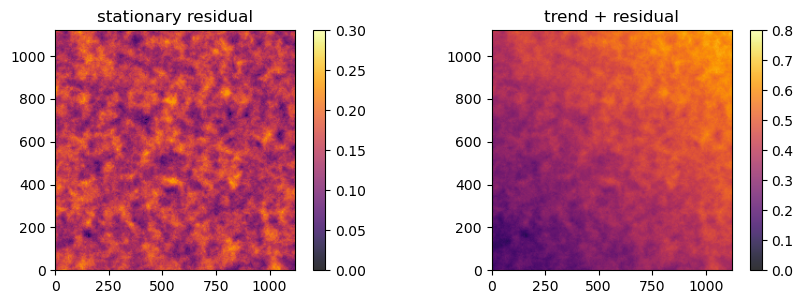

In [5]:
from scipy.ndimage import rotate
x = np.linspace(0,0.25,224)
xx, yy = np.flip(np.meshgrid(x,x))
trend = xx+yy
trend = rotate(trend,270,reshape=True)

#plot
plt.figure(figsize=(8,4))
cmap = plt.cm.inferno
plt.subplot(121) #stationary realization with range 100m
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,xsiz,0,0.3,'stationary residual','','','',cmap)

plt.subplot(122) # a linear trend + stationary realization
GSLIB.pixelplt_st(sim+trend,xmin,xmax,ymin,ymax,xsiz,0,0.8,'trend + residual','','','',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=0.6, wspace=0.2, hspace=0.3)